<a href="https://colab.research.google.com/github/KaranGond/BharatIntern/blob/main/tesla_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10
21/21 [==============================] - 10s 12ms/step - loss: 0.0365
Epoch 2/10
21/21 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 3/10
21/21 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 4/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 5/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 6/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 7/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 8/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 9/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 10/10
11/11 [==============================] - 1s 4ms/step
Root Mean Squared Error (RMSE): 11.758334582340108


<ipython-input-2-c7b1573f69f5>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


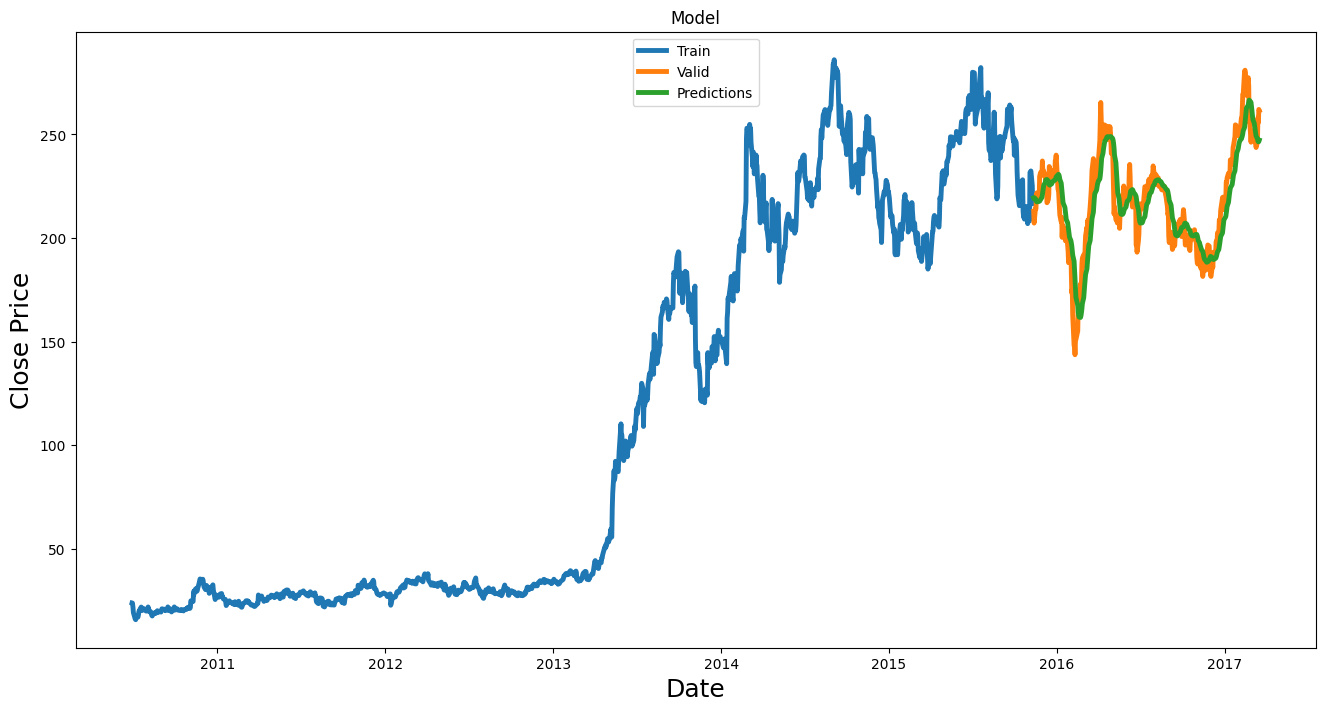

1/1 [==============================] - 0s 20ms/step
Predicted Next Day's Closing Price: 248.2775115966797


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math

# Load data
df = pd.read_csv('/content/drive/MyDrive/Tesla.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df.filter(['Close']).values

# Split data into training and testing sets
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

training_data_len = math.ceil(len(data) * 0.8)
train_data = scaled_data[:training_data_len]

x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=64, epochs=10)

# Prepare testing data
test_data = scaled_data[training_data_len-60:, :]
x_test, y_test = [], data[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize results
train = df.iloc[:training_data_len]
valid = df.iloc[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

plt.plot(train['Close'], linewidth=3.5)
plt.plot(valid[['Close', 'Predictions']], linewidth=3.5)

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper center')
plt.show()

# Predict the next day's closing price
last_60_days = scaled_data[-60:].reshape(1, -1, 1)
next_day_prediction = model.predict(last_60_days)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"Predicted Next Day's Closing Price: {next_day_prediction[0][0]}")
